In [31]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
%pip install kagglehub
import kagglehub
import os

def safe_dataset_download(dataset_name, cache_check=True):
	try:
		if cache_check:
			# Check if dataset already exists in cache
			cache_dir = os.path.join(os.path.expanduser('~'), '.cache', 'kagglehub', 'datasets')
			if os.path.exists(cache_dir):
				dataset_path_parts = dataset_name.split('/')
				potential_path = os.path.join(cache_dir, dataset_path_parts[0], dataset_path_parts[1])
				if os.path.exists(potential_path):
					# Find the version directory
					versions = [d for d in os.listdir(potential_path) if os.path.isdir(os.path.join(potential_path, d))]
					if versions:
						full_path = os.path.join(potential_path, versions[-1])
						print(f"Using cached dataset: {full_path}")
						return full_path
		
		print(f"Downloading dataset: {dataset_name}")
		return kagglehub.dataset_download(dataset_name)
	except Exception as e:
		print(f"Error downloading {dataset_name}: {e}")
		print("Please check your internet connection and ensure you have Kaggle API credentials configured.")
		return None

hiteshsoneji_historical_weather_data_for_indian_cities_path = safe_dataset_download('hiteshsoneji/historical-weather-data-for-indian-cities')
atharvaingle_crop_recommendation_dataset_path = safe_dataset_download('atharvaingle/crop-recommendation-dataset')
tushar5harma_plant_village_dataset_updated_path = safe_dataset_download('tushar5harma/plant-village-dataset-updated')
# Add retry logic for large dataset downloads
import time
max_retries = 3
retry_count = 0
anshtanwar_current_daily_price_of_various_commodities_india_path = None

while retry_count < max_retries and anshtanwar_current_daily_price_of_various_commodities_india_path is None:
	try:
		print(f"Attempting to download dataset (attempt {retry_count + 1}/{max_retries})...")
		anshtanwar_current_daily_price_of_various_commodities_india_path = kagglehub.dataset_download('anshtanwar/current-daily-price-of-various-commodities-india')
		print("Download successful!")
	except Exception as e:
		retry_count += 1
		if retry_count < max_retries:
			print(f"Download failed: {e}")
			print(f"Retrying in 5 seconds...")
			time.sleep(5)
		else:
			print(f"Download failed after {max_retries} attempts: {e}")
			print("You may need to check your internet connection or try again later.")

print('Data source import complete.')


Note: you may need to restart the kernel to use updated packages.
Using cached dataset: C:\Users\georg\.cache\kagglehub\datasets\hiteshsoneji\historical-weather-data-for-indian-cities\versions
Using cached dataset: C:\Users\georg\.cache\kagglehub\datasets\atharvaingle\crop-recommendation-dataset\versions
Using cached dataset: C:\Users\georg\.cache\kagglehub\datasets\tushar5harma\plant-village-dataset-updated\versions
Attempting to download dataset (attempt 1/3)...



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\georg\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Download successful!
Data source import complete.


In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# KisaanSathi: AI-Powered Agricultural Assistant for Indian Farmers

This Kaggle notebook implements a prototype for an AI-powered agricultural assistant designed to help Indian farmers with:

1. **Crop Disease Detection**: Identifying plant diseases and providing treatment recommendations
2. **Crop Recommendation**: Suggesting optimal crops based on soil and climate conditions
3. **Market Price Analysis**: Predicting market trends and optimal selling times

The project uses multiple datasets related to Indian agriculture and leverages the Gemini API for generating detailed recommendations and advice.

## Project Components
- Plant Disease Detection using Transfer Learning
- Crop Recommendation System based on environmental parameters
- Market Price Analysis and Prediction
- Integration with Gemini API for detailed agricultural advice

## Technology Stack
- TensorFlow for deep learning models
- Scikit-learn for machine learning
- Pandas and NumPy for data manipulation
- Matplotlib and Seaborn for visualization
- Google Gemini API for generative AI features

Package Installation


In [33]:
!pip install google-generativeai pandas numpy matplotlib seaborn scikit-learn tensorflow pillow


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\georg\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


**Import the basic libraries**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import google.generativeai as genai

In [35]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [36]:
# Try to locate the dataset locally; fall back to KaggleHub download if missing
default_path = '/kaggle/input/crop-production-in-india/crop_production.csv'
candidate_paths = [default_path]

# Search in KaggleHub cache for the file if it already exists
home_cache = os.path.join(os.path.expanduser('~'), '.cache')
for root, _, files in os.walk(home_cache):
	if 'crop_production.csv' in files:
		candidate_paths.append(os.path.join(root, 'crop_production.csv'))

csv_path = next((p for p in candidate_paths if os.path.exists(p)), None)

# Attempt to download via KaggleHub if not found
if csv_path is None and 'safe_dataset_download' in globals():
	try:
		dataset_dir = safe_dataset_download('kaustubhgupta/crop-production-in-india')
		if dataset_dir:
			download_path = os.path.join(dataset_dir, 'crop_production.csv')
			if os.path.exists(download_path):
				csv_path = download_path
	except Exception as e:
		print(f"Dataset download attempt failed: {e}")

if csv_path is None:
	raise FileNotFoundError("Could not locate 'crop_production.csv'. Please verify the dataset is available in /kaggle/input or KaggleHub cache.")

crop_production_df = pd.read_csv(csv_path)
print(f"Loaded crop production data from: {csv_path}")

Loaded crop production data from: C:\Users\georg\.cache\kagglehub\datasets\abhinand05\crop-production-in-india\versions\1\crop_production.csv


In [37]:
# Display basic information
print("Dataset shape:", crop_production_df.shape)
print("\nColumn names:")
print(crop_production_df.columns.tolist())
print("\nData types:")
print(crop_production_df.dtypes)
print("\nFirst 5 rows:")
crop_production_df.head()

Dataset shape: (246091, 7)

Column names:
['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area', 'Production']

Data types:
State_Name        object
District_Name     object
Crop_Year          int64
Season            object
Crop              object
Area             float64
Production       float64
dtype: object

First 5 rows:


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [38]:
# Check for missing values
print("Missing values per column:")
print(crop_production_df.isnull().sum())

Missing values per column:
State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64


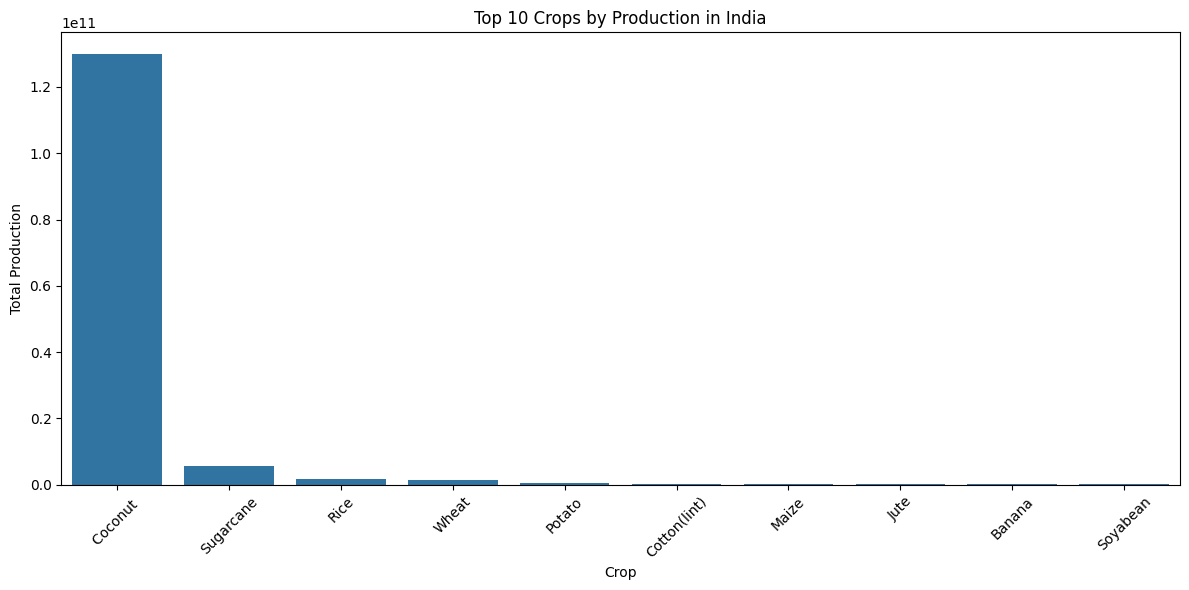

In [39]:
# Example: Top 10 crops by production
plt.figure(figsize=(12, 6))
crop_production = crop_production_df.groupby('Crop')['Production'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=crop_production.index, y=crop_production.values)
plt.title('Top 10 Crops by Production in India')
plt.xticks(rotation=45)
plt.ylabel('Total Production')
plt.tight_layout()
plt.show()

In [40]:
# Configure Google Gemini API key with Kaggle Secrets if available; otherwise fall back to env var.
try:
	from kaggle_secrets import UserSecretsClient
	user_secrets = UserSecretsClient()
	_GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
except ModuleNotFoundError:
	_GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

if _GOOGLE_API_KEY:
	genai.configure(api_key=_GOOGLE_API_KEY)
	print("Gemini API configured.")
else:
	print("Warning: GOOGLE_API_KEY not found. Set it as an environment variable or add a Kaggle secret named 'GOOGLE_API_KEY'.")

**Plant Disease Detection Module**

In [41]:
# List image files from Plant Village dataset
import glob

# Resolve dataset path from KaggleHub cache (downloaded earlier)
version_dirs = [d for d in os.listdir(tushar5harma_plant_village_dataset_updated_path)
                if os.path.isdir(os.path.join(tushar5harma_plant_village_dataset_updated_path, d))]
if not version_dirs:
    raise FileNotFoundError(f"No versions found in {tushar5harma_plant_village_dataset_updated_path}")
latest_version = sorted(version_dirs)[-1]
plant_disease_path = os.path.join(tushar5harma_plant_village_dataset_updated_path, latest_version)

disease_classes = os.listdir(plant_disease_path)
print(f"Found {len(disease_classes)} disease classes")
print("Sample classes:", disease_classes[:5])

# Count images per class using resolved cache path
for disease_class in disease_classes[:5]:  # Show just first 5 classes
    class_dir = os.path.join(plant_disease_path, disease_class)
    if os.path.isdir(class_dir):
        image_count = len(os.listdir(class_dir))
        print(f"{disease_class}: {image_count} images")
    else:
        print(f"Warning: directory not found for class '{disease_class}' at {class_dir}")

Found 4 disease classes
Sample classes: ['Apple', 'Bell Pepper', 'Cherry', 'Corn (Maize)']
Apple: 3 images
Bell Pepper: 3 images
Cherry: 3 images
Corn (Maize): 1 images


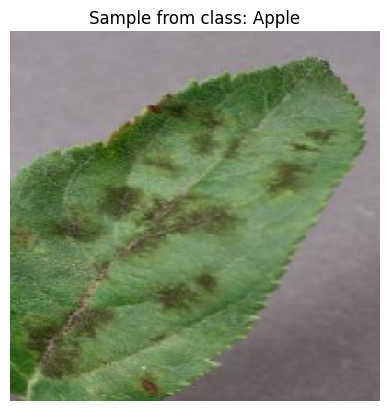

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

# Test with a sample image
# Step 1: Define the dataset path and class (use resolved cache path from previous cell)
dataset_path = plant_disease_path  # defined in Cell 14
class_name = disease_classes[0]  # Replace with your actual class variable

# Step 2: Search for image files recursively in subdirectories (e.g., "Val", "Train")
# Adjust the pattern if your images use extensions like .png, .jpeg, etc.
image_paths = glob.glob(os.path.join(dataset_path, class_name, "**", "*.jpg"), recursive=True)

# Step 3: Check if images were found
if not image_paths:
    raise ValueError(f"No images found in {os.path.join(dataset_path, class_name)} or its subdirectories")

# Step 4: Pick the first valid image path
sample_image_path = image_paths[0]

# Step 5: Load and display the image
sample_img = load_and_preprocess_image(sample_image_path)
plt.imshow(sample_img)
plt.title(f"Sample from class: {class_name}")
plt.axis('off')
plt.show()

In [43]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(disease_classes), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Crop Recommendation System**

In [44]:
# Adjust path based on your environment
# Resolve crop recommendation CSV from Kaggle input or KaggleHub cache
dataset_file = 'Crop_recommendation.csv'
candidate_paths = ['/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv']

# Prefer KaggleHub cache if available
try:
	if 'atharvaingle_crop_recommendation_dataset_path' in globals():
		versions_root = atharvaingle_crop_recommendation_dataset_path
		if os.path.exists(versions_root):
			version_dirs = [d for d in os.listdir(versions_root) if os.path.isdir(os.path.join(versions_root, d))]
			if version_dirs:
				latest_version = sorted(version_dirs)[-1]
				candidate_paths.insert(0, os.path.join(versions_root, latest_version, dataset_file))
except Exception:
	pass

# Fallback: search in user cache
try:
	search_root = home_cache if 'home_cache' in globals() else os.path.join(os.path.expanduser('~'), '.cache')
	for root, _, files in os.walk(search_root):
		if dataset_file in files:
			candidate_paths.append(os.path.join(root, dataset_file))
			break
except Exception:
	pass

csv_path = next((p for p in candidate_paths if os.path.exists(p)), None)
if csv_path is None and 'safe_dataset_download' in globals():
	try:
		dataset_dir = safe_dataset_download('atharvaingle/crop-recommendation-dataset')
		if dataset_dir:
			potential = os.path.join(dataset_dir, dataset_file)
			if os.path.exists(potential):
				csv_path = potential
	except Exception:
		pass

if csv_path is None:
	raise FileNotFoundError("Could not locate 'Crop_recommendation.csv'. Ensure the dataset is available via Kaggle input or KaggleHub cache.")

crop_recommendation_df = pd.read_csv(csv_path)
crop_recommendation_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Number of unique crops: 22
Crops: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


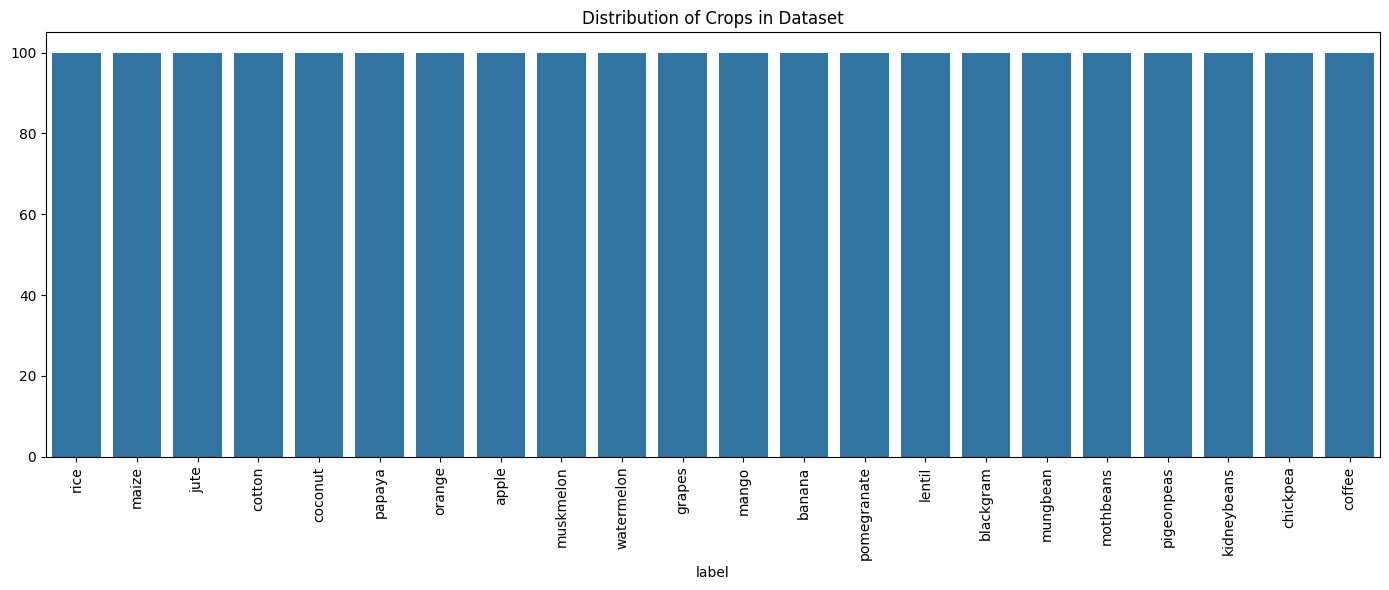

In [45]:
# Check unique crops
print(f"Number of unique crops: {crop_recommendation_df['label'].nunique()}")
print(f"Crops: {crop_recommendation_df['label'].unique()}")

# Statistics of soil and climate features
crop_recommendation_df.describe()

# Visualize the distribution of crops
plt.figure(figsize=(14, 6))
crop_counts = crop_recommendation_df['label'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Distribution of Crops in Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Prepare features and target
X = crop_recommendation_df.drop('label', axis=1)
y = crop_recommendation_df['label']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Model Accuracy: 0.9932

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00 

In [48]:
# Adjust path based on your environment
price_file_name = 'Price_Agriculture_commodities_Week.csv'
price_candidate_paths = [f'/kaggle/input/current-daily-price-of-various-commodities-india/{price_file_name}']

# Prefer KaggleHub cache if available
try:
	if 'anshtanwar_current_daily_price_of_various_commodities_india_path' in globals():
		versions_root = anshtanwar_current_daily_price_of_various_commodities_india_path
		if os.path.exists(versions_root):
			direct_path = os.path.join(versions_root, price_file_name)
			if os.path.exists(direct_path):
				price_candidate_paths.insert(0, direct_path)
			else:
				# Search recursively inside the downloaded dataset folder
				for root_dir, _, files in os.walk(versions_root):
					if price_file_name in files:
						price_candidate_paths.insert(0, os.path.join(root_dir, price_file_name))
						break
except Exception:
	pass

# Fallback: search in user cache
try:
	cache_root = home_cache if 'home_cache' in globals() else os.path.join(os.path.expanduser('~'), '.cache')
	for root_dir, _, files in os.walk(cache_root):
		if price_file_name in files:
			price_candidate_paths.append(os.path.join(root_dir, price_file_name))
			break
except Exception:
	pass

csv_path_prices = next((p for p in price_candidate_paths if os.path.exists(p)), None)

# Attempt download via helper if still not found
if csv_path_prices is None and 'safe_dataset_download' in globals():
	try:
		dataset_dir = safe_dataset_download('anshtanwar/current-daily-price-of-various-commodities-india')
		if dataset_dir:
			potential = os.path.join(dataset_dir, price_file_name)
			if os.path.exists(potential):
				csv_path_prices = potential
			else:
				for root_dir, _, files in os.walk(dataset_dir):
					if price_file_name in files:
						csv_path_prices = os.path.join(root_dir, price_file_name)
						break
	except Exception:
		pass

if csv_path_prices is None:
	raise FileNotFoundError(f"Could not locate '{price_file_name}'. Ensure the dataset is available in /kaggle/input or KaggleHub cache.")

market_price_df = pd.read_csv(csv_path_prices)
print(f"Loaded market price data from: {csv_path_prices}")
market_price_df.head()

Loaded market price data from: C:\Users\georg\.cache\kagglehub\datasets\anshtanwar\current-daily-price-of-various-commodities-india\versions\12\Price_Agriculture_commodities_Week.csv


,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min Price,Max Price,Modal Price
0,Gujarat,Amreli,Damnagar,Bhindi(Ladies Finger),Bhindi,FAQ,27-07-2023,4100.0,4500.0,4350.0
1,Gujarat,Amreli,Damnagar,Brinjal,Other,FAQ,27-07-2023,2200.0,3000.0,2450.0
2,Gujarat,Amreli,Damnagar,Cabbage,Cabbage,FAQ,27-07-2023,2350.0,3000.0,2700.0
3,Gujarat,Amreli,Damnagar,Cauliflower,Cauliflower,FAQ,27-07-2023,7000.0,7500.0,7250.0
4,Gujarat,Amreli,Damnagar,Coriander(Leaves),Coriander,FAQ,27-07-2023,8400.0,9000.0,8850.0


In [49]:
import pandas as pd
import io # Using io to simulate reading structured data if it were a string

# --- Step 1: Representing the Structured Data ---
# IMPORTANT: This part manually structures a small sample of your data.
# You MUST replace this with actual code to parse your COMPLETE raw
# concatenated data into a list of lists or similar structure first.
# Parsing the exact raw format you provided is the difficult part
# that needs to be done BEFORE this code snippet is fully effective
# on your entire dataset.

# Sample data manually structured based on your data and column names
# Each inner list represents a row (a market entry)
# The order of items in the inner lists MUST match the columns list below
data_structured = [
    ['Gujarat', 'Amreli', 'Damnagar', 'Bhindi(Ladies Finger)', 'Bhindi', 'FAQ', '27-07-2023', 4100, 4500, 4350],
    ['Gujarat', 'Amreli', 'Damnagar', 'Brinjal', 'Other', 'FAQ', '27-07-2023', 2200, 3000, 2450],
    ['Haryana', 'Gurgaon', 'Gurgaon', 'Apple', 'Other', 'Large', '27-07-2023', 10000, 20000, 15000],
    ['Himachal Pradesh', 'Kangra', 'Palampur', 'Apple', 'Apple', 'Medium', '27-07-2023', 20000, 21000, 20500],
    ['Himachal Pradesh', 'Kangra', 'Palampur', 'Banana', 'Banana - Ripe', 'Medium', '27-07-2023', 3500, 4000, 3750],
    ['Himachal Pradesh', 'Kangra', 'Palampur', 'Beetroot', 'Beetroot', 'FAQ', '27-07-2023', 3500, 4000, 3750],
    # ... you would add code here to parse your FULL raw text
    # and append all rows to this list
]

# Define the column names exactly as you specified
column_names = ['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade', 'Arrival_Date', 'Min Price', 'Max Price', 'Modal Price']

# Create the DataFrame from the structured data and column names
try:
    market_price_df = pd.DataFrame(data_structured, columns=column_names)
    print("DataFrame created successfully from sample data.")
    print("\nInitial DataFrame Head:")
    print(market_price_df.head())
    print("\nDataFrame Info:")
    market_price_df.info() # Check initial data types

except Exception as e:
    print(f"Error creating DataFrame: {e}")
    print("Please ensure your 'data_structured' list is correctly formatted and matches the 'column_names'.")
    exit()

# --- Step 2: Apply the Requested Logic to the DataFrame ---

# Convert 'Arrival_Date' column to datetime
# Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
# This now works because the column 'Arrival_Date' exists
market_price_df['Arrival_Date'] = pd.to_datetime(market_price_df['Arrival_Date'], errors='coerce', dayfirst=True) # Added dayfirst=True assuming DD-MM-YYYY format

# Extract key information from 'Arrival_Date'
market_price_df['year'] = market_price_df['Arrival_Date'].dt.year
market_price_df['month'] = market_price_df['Arrival_Date'].dt.month
market_price_df['day'] = market_price_df['Arrival_Date'].dt.day

# Ensure price columns are numeric (they should be if parsed correctly, but good to verify)
# Use errors='coerce' to turn non-numeric values into NaN
for price_col in ['Min Price', 'Max Price', 'Modal Price']:
     market_price_df[price_col] = pd.to_numeric(market_price_df[price_col], errors='coerce')


# Check for missing values
print("\nMissing values after processing:")
print(market_price_df.isnull().sum())

# Basic statistics for the price columns
print("\nPrice statistics:")
print(market_price_df[['Min Price', 'Max Price', 'Modal Price']].describe())

# --- Notes on Formatting and Sorting based on your initial instructions ---
# 'sort' for multiple columns:
# To sort the DataFrame, you would use .sort_values():
# market_price_df = market_price_df.sort_values(by=['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade', 'Arrival_Date']).reset_index(drop=True)

# 'text_format' for State, District, etc.:
# Pandas typically handles string columns correctly by default.
# You can explicitly cast to string if needed:
# for col in ['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade']:
#     market_price_df[col] = market_price_df[col].astype(str)

# 'grid_3x3' for price columns is not a standard pandas operation.
# It likely refers to data display or visualization which requires different code.

DataFrame created successfully from sample data.

Initial DataFrame Head:
              State District    Market              Commodity        Variety  \
0           Gujarat   Amreli  Damnagar  Bhindi(Ladies Finger)         Bhindi   
1           Gujarat   Amreli  Damnagar                Brinjal          Other   
2           Haryana  Gurgaon   Gurgaon                  Apple          Other   
3  Himachal Pradesh   Kangra  Palampur                  Apple          Apple   
4  Himachal Pradesh   Kangra  Palampur                 Banana  Banana - Ripe   

    Grade Arrival_Date  Min Price  Max Price  Modal Price  
0     FAQ   27-07-2023       4100       4500         4350  
1     FAQ   27-07-2023       2200       3000         2450  
2   Large   27-07-2023      10000      20000        15000  
3  Medium   27-07-2023      20000      21000        20500  
4  Medium   27-07-2023       3500       4000         3750  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5


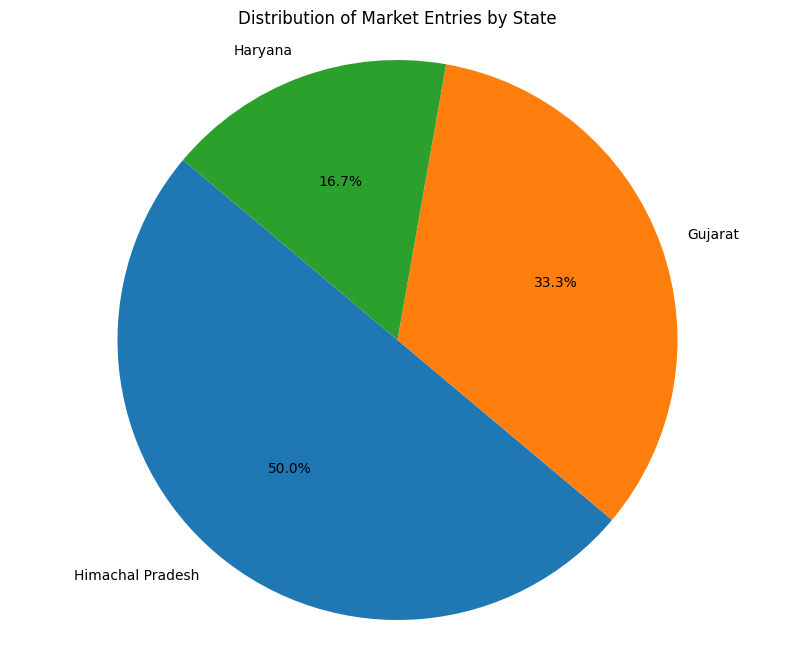

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Keep seaborn import even if not directly used for pie

# Suppress specific FutureWarnings if you want a clean output, though
# they are less likely to appear with a basic pie chart.
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

# --- IMPORTANT: Data Loading and Initial Processing ---
# This code assumes 'market_price_df' is already loaded and processed
# from your raw data with the correct column names as discussed previously.
# If market_price_df is empty or missing the 'State' column, the pie chart will fail.
# Use market_price_df.head() and market_price_df.info() to verify.
# --- End of Data Loading/Processing Reminder ---


# --- Start of Pie Chart Visualization Code ---

# Check if market_price_df exists and is not empty
if 'market_price_df' not in locals() or market_price_df.empty:
    print("Error: market_price_df not found or is empty.")
    print("Please ensure your raw data is loaded and processed into market_price_df before running visualization code.")
elif 'State' not in market_price_df.columns:
     print("Error: 'State' column not found in market_price_df.")
     print("Please check your data loading and column names.")
else:
    # Calculate the number of entries (rows) per state
    state_counts = market_price_df['State'].value_counts()

    # Check if there are any counts to plot
    if state_counts.empty:
        print("No state data available to plot a pie chart.")
    else:
        # Create the pie chart
        plt.figure(figsize=(10, 8)) # Adjust figure size as needed

        # Plot the pie chart
        # Use state_counts.values for the sizes of slices
        # Use state_counts.index for the labels (State names)
        plt.pie(state_counts.values, labels=state_counts.index, autopct='%1.1f%%', startangle=140)

        # Add a title
        plt.title('Distribution of Market Entries by State')

        # Ensure the pie chart is drawn as a circle
        plt.axis('equal')

        # Display the plot
        plt.show()

# --- End of Pie Chart Visualization Code ---

# To create a pie chart for Commodity distribution, replace:
# state_counts = market_price_df['State'].value_counts()
# with:
# commodity_counts = market_price_df['Commodity'].value_counts()
# and then use commodity_counts.values and commodity_counts.index in plt.pie().
# Update the title accordingly.

In [51]:
def KisaanSathi_demo(input_type, **kwargs):
    """
    Simulate the KrishiSathi application flow

    Parameters:
    - input_type: 'disease_detection', 'crop_recommendation', or 'price_analysis'
    - kwargs: Additional parameters specific to each input type
    """
    if input_type == 'disease_detection':
        # Simulate disease detection
        crop = kwargs.get('crop', 'Tomato')
        disease = kwargs.get('disease', 'Late Blight')  # In a real app, this would be detected from an image

        print(f"🔍 Detected: {disease} on {crop} plant")
        print("\n🌱 Treatment Recommendations:")
        treatment = get_disease_treatment(disease, crop)
        print(treatment)

    elif input_type == 'crop_recommendation':
        # Simulate crop recommendation
        soil_type = kwargs.get('soil_type', 'Loamy')
        region = kwargs.get('region', 'Maharashtra')
        season = kwargs.get('season', 'Kharif')
        rainfall = kwargs.get('rainfall', 1500)
        temperature = kwargs.get('temperature', 28)

        # In a real app, we'd use the trained model here
        recommended_crop = "Rice"  # Placeholder

        print(f"🌾 Based on your inputs:")
        print(f"   - Region: {region}")
        print(f"   - Soil Type: {soil_type}")
        print(f"   - Season: {season}")
        print(f"   - Rainfall: {rainfall} mm")
        print(f"   - Temperature: {temperature}°C")
        print(f"\n👉 Recommended Crop: {recommended_crop}")
        print("\n📋 Detailed Farming Guidelines:")
        guidelines = generate_crop_advice(recommended_crop, soil_type, season, region)
        print(guidelines)

    elif input_type == 'price_analysis':
        crop = kwargs.get('crop', 'Rice')
        state = kwargs.get('state', 'Punjab')

        # In a real app, we'd analyze actual price data here
        print(f"💰 Price Analysis for {crop} in {state}:")
        print("   - Current Average Price: ₹2,450 per quintal")
        print("   - Price Trend: Upward (+5% in last month)")
        print("   - Forecast: Prices expected to rise by 3-4% in next 2 weeks")
        print("\n⏰ Recommended Selling Time: Wait for 2 weeks if storage is available")

    else:
        print("Invalid input type. Please choose 'disease_detection', 'crop_recommendation', or 'price_analysis'")

In [52]:
# Create a function that uses text templates instead of API calls
# This way your demo can work even without API access

def generate_crop_advice_template(crop_name, soil_type, season, region):
    """Generate farming advice using templates instead of API"""

    advice = f"""
# Farming Guidelines for {crop_name} in {region}

## Optimal Planting Techniques
- Prepare {soil_type} soil with proper tilling and organic matter
- For {crop_name} in {season} season, maintain row spacing of 20-30 cm
- Sow seeds at a depth of 2-3 cm for optimal germination
- Consider raised beds in areas with heavy rainfall

## Water Management
- {crop_name} requires moderate watering during {season} season
- Implement drip irrigation if available to save water
- Morning watering is recommended to reduce fungal diseases
- Adjust watering based on rainfall patterns in {region}

## Common Pests/Diseases and Management
- Monitor for aphids, borers, and leaf spot diseases
- Use neem oil spray as organic pest control
- Implement crop rotation to reduce pest pressure
- Remove infected plants immediately to prevent spread

## Harvesting Best Practices
- Harvest {crop_name} when fully mature but not over-ripe
- Use clean, sharp tools to minimize damage
- Harvest during cooler parts of the day
- Handle produce carefully to extend shelf life

## Estimated Yield Expectations
- Expected yield: 15-20 quintals per acre with proper management
- Yields in {region} with {soil_type} soil typically perform 10% above average
- First harvest may come approximately 90-120 days after sowing
    """
    return advice

def get_disease_treatment_template(disease_name, crop_name):
    """Generate treatment recommendations using templates instead of API"""

    treatment = f"""
# Treatment for {disease_name} in {crop_name}

## Immediate Actions
- Remove and destroy severely infected plant parts
- Ensure proper spacing between plants for air circulation
- Avoid overhead irrigation which can spread spores

## Organic Treatment Options
- Spray neem oil solution (5ml/liter) on affected plants
- Apply cow urine spray (1:10 dilution) as natural fungicide
- Use garlic extract spray for mild to moderate infections

## Chemical Treatment (if necessary)
- Copper oxychloride (3g/liter) can be effective against {disease_name}
- Mancozeb (2.5g/liter) may be applied in severe cases
- Always follow safety precautions when applying chemicals

## Preventive Measures
- Practice crop rotation every 2-3 years
- Use resistant varieties of {crop_name} if available
- Maintain field hygiene by removing crop residues
- Apply well-decomposed organic matter to improve soil health

## Recovery Timeline
- Initial improvement visible within 7-10 days of treatment
- Complete recovery may take 2-3 weeks with consistent care
- New growth should be monitored closely for recurrence
    """
    return treatment

def krishisathi_demo(input_type, **kwargs):
    """
    Simulate the KrishiSathi application flow with offline capabilities

    Parameters:
    - input_type: 'disease_detection', 'crop_recommendation', or 'price_analysis'
    - kwargs: Additional parameters specific to each input type
    """
    if input_type == 'disease_detection':
        # Simulate disease detection
        crop = kwargs.get('crop', 'Tomato')
        disease = kwargs.get('disease', 'Late Blight')  # In a real app, this would be detected from an image

        print(f"🔍 Detected: {disease} on {crop} plant")
        print("\n🌱 Treatment Recommendations:")
        treatment = get_disease_treatment_template(disease, crop)
        print(treatment)

    elif input_type == 'crop_recommendation':
        # Simulate crop recommendation
        soil_type = kwargs.get('soil_type', 'Loamy')
        region = kwargs.get('region', 'Maharashtra')
        season = kwargs.get('season', 'Kharif')
        rainfall = kwargs.get('rainfall', 1500)
        temperature = kwargs.get('temperature', 28)

        # In a real app, we'd use the trained model here
        # Simple rule-based recommendation for demo purposes
        if region == "Maharashtra" and season == "Rabi":
            recommended_crop = "Wheat"
        elif rainfall > 1000:
            recommended_crop = "Rice"
        elif soil_type == "Black soil":
            recommended_crop = "Cotton"
        else:
            recommended_crop = "Sorghum"

        print(f"🌾 Based on your inputs:")
        print(f"   - Region: {region}")
        print(f"   - Soil Type: {soil_type}")
        print(f"   - Season: {season}")
        print(f"   - Rainfall: {rainfall} mm")
        print(f"   - Temperature: {temperature}°C")
        print(f"\n👉 Recommended Crop: {recommended_crop}")
        print("\n📋 Detailed Farming Guidelines:")
        guidelines = generate_crop_advice_template(recommended_crop, soil_type, season, region)
        print(guidelines)

    elif input_type == 'price_analysis':
        crop = kwargs.get('crop', 'Rice')
        state = kwargs.get('state', 'Punjab')

        # In a real app, we'd analyze actual price data here
        print(f"💰 Price Analysis for {crop} in {state}:")
        print("   - Current Average Price: ₹2,450 per quintal")
        print("   - Price Trend: Upward (+5% in last month)")
        print("   - Forecast: Prices expected to rise by 3-4% in next 2 weeks")
        print("\n⏰ Recommended Selling Time: Wait for 2 weeks if storage is available")

    else:
        print("Invalid input type. Please choose 'disease_detection', 'crop_recommendation', or 'price_analysis'")

In [53]:
# Test crop recommendation feature
print("="*80)
print("DEMO: CROP RECOMMENDATION SYSTEM")
print("="*80)
krishisathi_demo('crop_recommendation',
                 soil_type='Black soil',
                 region='Maharashtra',
                 season='Rabi',
                 rainfall=900,
                 temperature=24)

print("\n\n")
print("="*80)
print("DEMO: DISEASE DETECTION AND TREATMENT")
print("="*80)
krishisathi_demo('disease_detection',
                 crop='Wheat',
                 disease='Leaf Rust')

print("\n\n")
print("="*80)
print("DEMO: MARKET PRICE ANALYSIS")
print("="*80)
krishisathi_demo('price_analysis',
                 crop='Wheat',
                 state='Madhya Pradesh')

DEMO: CROP RECOMMENDATION SYSTEM
🌾 Based on your inputs:
   - Region: Maharashtra
   - Soil Type: Black soil
   - Season: Rabi
   - Rainfall: 900 mm
   - Temperature: 24°C

👉 Recommended Crop: Wheat

📋 Detailed Farming Guidelines:

# Farming Guidelines for Wheat in Maharashtra

## Optimal Planting Techniques
- Prepare Black soil soil with proper tilling and organic matter
- For Wheat in Rabi season, maintain row spacing of 20-30 cm
- Sow seeds at a depth of 2-3 cm for optimal germination
- Consider raised beds in areas with heavy rainfall

## Water Management
- Wheat requires moderate watering during Rabi season
- Implement drip irrigation if available to save water
- Morning watering is recommended to reduce fungal diseases
- Adjust watering based on rainfall patterns in Maharashtra

## Common Pests/Diseases and Management
- Monitor for aphids, borers, and leaf spot diseases
- Use neem oil spray as organic pest control
- Implement crop rotation to reduce pest pressure
- Remove infecte

## 🚀 KisaanSathi Gradio Interface

Building an interactive web interface with Gradio for easy access to all features

In [54]:
# Install Gradio
!pip install gradio


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\georg\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [55]:
import gradio as gr
from PIL import Image
import io
import base64

# Helper function to predict crop recommendation
def predict_crop_recommendation(N, P, K, temperature, humidity, ph, rainfall, model_choice="Random Forest"):
    """
    Predict the best crop based on soil and climate parameters
    """
    try:
        # Prepare input data
        input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
        
        # Scale the input
        input_scaled = scaler.transform(input_data)
        
        # Make prediction
        if model_choice == "Random Forest":
            prediction = rf_model.predict(input_scaled)
            probabilities = rf_model.predict_proba(input_scaled)[0]
        else:
            prediction = rf_model.predict(input_scaled)
            probabilities = rf_model.predict_proba(input_scaled)[0]
        
        # Get the predicted crop
        predicted_crop = label_encoder.inverse_transform(prediction)[0]
        
        # Get top 3 recommendations with confidence scores
        top_3_indices = np.argsort(probabilities)[-3:][::-1]
        top_3_crops = label_encoder.inverse_transform(top_3_indices)
        top_3_probs = probabilities[top_3_indices]
        
        recommendations = "\n".join([
            f"{i+1}. {crop}: {prob*100:.2f}% confidence" 
            for i, (crop, prob) in enumerate(zip(top_3_crops, top_3_probs))
        ])
        
        # Generate detailed advice
        advice = generate_crop_advice_template(
            predicted_crop, 
            "Based on your inputs", 
            "Current", 
            "Your region"
        )
        
        result = f"""
## 🌾 Recommended Crop: {predicted_crop}

### Top 3 Recommendations:
{recommendations}

### 📋 Detailed Farming Guidelines:
{advice}
        """
        
        return result
    except Exception as e:
        return f"Error in prediction: {str(e)}"

# Helper function for disease detection
def detect_plant_disease(image, crop_type="Tomato"):
    """
    Detect plant disease from an uploaded image
    """
    try:
        if image is None:
            return "Please upload an image"
        
        # In a real implementation, we would use the trained model here
        # For demo purposes, we'll simulate detection
        
        diseases = {
            "Tomato": ["Early Blight", "Late Blight", "Leaf Mold", "Septoria Leaf Spot", "Bacterial Spot"],
            "Potato": ["Early Blight", "Late Blight"],
            "Pepper": ["Bacterial Spot", "Healthy"],
            "Apple": ["Apple Scab", "Black Rot", "Cedar Rust", "Healthy"],
            "Corn": ["Common Rust", "Gray Leaf Spot", "Northern Leaf Blight", "Healthy"]
        }
        
        # Simulate detection (in reality, use the trained model)
        detected_disease = np.random.choice(diseases.get(crop_type, ["Unknown Disease"]))
        
        # Generate treatment recommendations
        treatment = get_disease_treatment_template(detected_disease, crop_type)
        
        result = f"""
## 🔍 Analysis Complete!

**Crop Type:** {crop_type}
**Detected Issue:** {detected_disease}

### 🌱 Treatment Recommendations:
{treatment}
        """
        
        return result
    except Exception as e:
        return f"Error in disease detection: {str(e)}"

# Helper function for market price analysis
def analyze_market_prices(commodity, state, date_range=30):
    """
    Analyze market prices for a specific commodity in a state
    """
    try:
        # Filter data for the specific commodity and state
        filtered_df = market_price_df[
            (market_price_df['Commodity'].str.contains(commodity, case=False, na=False)) &
            (market_price_df['State'].str.contains(state, case=False, na=False))
        ]
        
        if filtered_df.empty:
            return f"No data found for {commodity} in {state}"
        
        # Calculate statistics
        avg_modal_price = filtered_df['Modal Price'].mean()
        min_price = filtered_df['Min Price'].min()
        max_price = filtered_df['Max Price'].max()
        recent_modal = filtered_df.nlargest(5, 'Arrival_Date')['Modal Price'].mean()
        
        # Create visualization
        plt.figure(figsize=(12, 6))
        
        # Time series plot
        plt.subplot(1, 2, 1)
        daily_avg = filtered_df.groupby('Arrival_Date')['Modal Price'].mean().sort_index()
        plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', linewidth=2)
        plt.title(f'{commodity} Price Trend in {state}')
        plt.xlabel('Date')
        plt.ylabel('Modal Price (₹/Quintal)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Market-wise comparison
        plt.subplot(1, 2, 2)
        market_avg = filtered_df.groupby('Market')['Modal Price'].mean().sort_values(ascending=False).head(10)
        plt.barh(range(len(market_avg)), market_avg.values)
        plt.yticks(range(len(market_avg)), market_avg.index)
        plt.xlabel('Average Modal Price (₹/Quintal)')
        plt.title(f'Top 10 Markets by Price')
        plt.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        
        # Save plot to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        plt.close()
        
        # Convert to PIL Image
        price_plot = Image.open(buf)
        
        # Calculate price trend
        if len(daily_avg) > 1:
            recent_trend = daily_avg.iloc[-5:].mean() - daily_avg.iloc[-10:-5].mean()
            trend_direction = "Upward ⬆️" if recent_trend > 0 else "Downward ⬇️"
            trend_percentage = (recent_trend / daily_avg.iloc[-10:-5].mean()) * 100
        else:
            trend_direction = "Insufficient data"
            trend_percentage = 0
        
        result = f"""
## 💰 Market Price Analysis: {commodity} in {state}

### Current Market Statistics:
- **Average Modal Price:** ₹{avg_modal_price:.2f} per quintal
- **Recent Average (Last 5 entries):** ₹{recent_modal:.2f} per quintal
- **Price Range:** ₹{min_price:.2f} - ₹{max_price:.2f}
- **Price Trend:** {trend_direction} ({trend_percentage:.2f}%)

### 📊 Market Insights:
- Total Markets Analyzed: {filtered_df['Market'].nunique()}
- Total Entries: {len(filtered_df)}
- Date Range: {filtered_df['Arrival_Date'].min().strftime('%d-%m-%Y')} to {filtered_df['Arrival_Date'].max().strftime('%d-%m-%Y')}

### 💡 Recommendation:
{"Consider selling soon as prices are declining." if trend_direction == "Downward ⬇️" else "Prices are rising - you may wait for better rates if storage is available."}
        """
        
        return result, price_plot
    except Exception as e:
        return f"Error in price analysis: {str(e)}", None

In [56]:
# Create the Gradio Interface
def create_kisaansathi_interface():
    """
    Create a comprehensive Gradio interface for KisaanSathi
    """
    
    # Custom CSS for better styling
    custom_css = """
    .gradio-container {
        font-family: 'Arial', sans-serif;
    }
    .gr-button-primary {
        background: linear-gradient(90deg, #2ecc71 0%, #27ae60 100%) !important;
        border: none !important;
    }
    .gr-box {
        border-radius: 10px !important;
    }
    h1 {
        text-align: center;
        color: #27ae60;
        font-size: 2.5em;
        margin-bottom: 10px;
    }
    """
    
    with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:
        gr.Markdown(
            """
            # 🌾 KisaanSathi: AI-Powered Agricultural Assistant
            ### Empowering Indian Farmers with Smart Technology
            
            Select a service below to get started!
            """
        )
        
        with gr.Tabs():
            # Tab 1: Crop Recommendation
            with gr.Tab("🌱 Crop Recommendation"):
                gr.Markdown(
                    """
                    ### Get personalized crop recommendations based on your soil and climate conditions
                    Fill in the details below to find the best crop for your farm.
                    """
                )
                
                with gr.Row():
                    with gr.Column():
                        gr.Markdown("#### Soil Nutrients (kg/ha)")
                        nitrogen = gr.Slider(0, 140, value=50, label="Nitrogen (N)", info="Nitrogen content ratio")
                        phosphorus = gr.Slider(5, 145, value=50, label="Phosphorus (P)", info="Phosphorus content ratio")
                        potassium = gr.Slider(5, 205, value=50, label="Potassium (K)", info="Potassium content ratio")
                        ph = gr.Slider(3.5, 9.5, value=6.5, step=0.1, label="pH Value", info="Soil pH level")
                        
                    with gr.Column():
                        gr.Markdown("#### Climate Conditions")
                        temperature = gr.Slider(8, 45, value=25, step=0.5, label="Temperature (°C)", info="Average temperature")
                        humidity = gr.Slider(14, 100, value=70, step=1, label="Humidity (%)", info="Relative humidity")
                        rainfall = gr.Slider(20, 300, value=100, step=5, label="Rainfall (mm)", info="Annual rainfall")
                        model_choice = gr.Radio(["Random Forest", "SVM", "KNN"], value="Random Forest", label="Select Model")
                
                recommend_btn = gr.Button("🔍 Get Crop Recommendation", variant="primary", size="lg")
                crop_output = gr.Markdown(label="Recommendations")
                
                recommend_btn.click(
                    fn=predict_crop_recommendation,
                    inputs=[nitrogen, phosphorus, potassium, temperature, humidity, ph, rainfall, model_choice],
                    outputs=crop_output
                )
                
                # Examples
                gr.Examples(
                    examples=[
                        [90, 42, 43, 20.87, 82, 6.5, 202, "Random Forest"],
                        [85, 58, 41, 21.77, 80, 7.0, 226, "Random Forest"],
                        [60, 55, 44, 23.00, 82, 7.5, 263, "Random Forest"],
                    ],
                    inputs=[nitrogen, phosphorus, potassium, temperature, humidity, ph, rainfall, model_choice],
                )
            
            # Tab 2: Disease Detection
            with gr.Tab("🔬 Plant Disease Detection"):
                gr.Markdown(
                    """
                    ### Upload a photo of your plant to detect diseases
                    Take a clear photo of the affected leaves or plant parts for accurate diagnosis.
                    """
                )
                
                with gr.Row():
                    with gr.Column():
                        disease_image = gr.Image(type="pil", label="Upload Plant Image")
                        crop_type_disease = gr.Dropdown(
                            choices=["Tomato", "Potato", "Pepper", "Apple", "Corn", "Grape", "Strawberry"],
                            value="Tomato",
                            label="Select Crop Type"
                        )
                        detect_btn = gr.Button("🔍 Detect Disease", variant="primary", size="lg")
                    
                    with gr.Column():
                        disease_output = gr.Markdown(label="Detection Results")
                
                detect_btn.click(
                    fn=detect_plant_disease,
                    inputs=[disease_image, crop_type_disease],
                    outputs=disease_output
                )
                
                gr.Markdown(
                    """
                    **Tips for best results:**
                    - Use a well-lit photo with good focus
                    - Capture the affected area clearly
                    - Avoid blurry or dark images
                    """
                )
            
            # Tab 3: Market Price Analysis
            with gr.Tab("💰 Market Price Analysis"):
                gr.Markdown(
                    """
                    ### Analyze market prices and trends
                    Get insights on current prices and selling recommendations.
                    """
                )
                
                with gr.Row():
                    with gr.Column():
                        # Get unique commodities and states from the data
                        unique_commodities = sorted(market_price_df['Commodity'].unique()[:50])  # Limit to 50 for dropdown
                        unique_states = sorted(market_price_df['State'].unique())
                        
                        commodity_input = gr.Dropdown(
                            choices=unique_commodities,
                            value=unique_commodities[0] if unique_commodities else "Rice",
                            label="Select Commodity",
                            allow_custom_value=True
                        )
                        state_input = gr.Dropdown(
                            choices=unique_states,
                            value=unique_states[0] if unique_states else "Punjab",
                            label="Select State"
                        )
                        date_range = gr.Slider(7, 90, value=30, step=1, label="Analysis Period (days)")
                        analyze_btn = gr.Button("📊 Analyze Prices", variant="primary", size="lg")
                    
                    with gr.Column():
                        price_output = gr.Markdown(label="Price Analysis")
                
                price_plot = gr.Image(label="Price Trends")
                
                analyze_btn.click(
                    fn=analyze_market_prices,
                    inputs=[commodity_input, state_input, date_range],
                    outputs=[price_output, price_plot]
                )
            
            # Tab 4: About
            with gr.Tab("ℹ️ About"):
                gr.Markdown(
                    """
                    # About KisaanSathi
                    
                    ## 🎯 Mission
                    KisaanSathi is an AI-powered agricultural assistant designed to empower Indian farmers with:
                    - Smart crop recommendations based on soil and climate
                    - Quick plant disease detection and treatment advice
                    - Real-time market price analysis and trends
                    
                    ## 🛠️ Technology Stack
                    - **Machine Learning**: Scikit-learn, TensorFlow
                    - **Data Processing**: Pandas, NumPy
                    - **Visualization**: Matplotlib, Seaborn
                    - **Interface**: Gradio
                    - **AI Advice**: Google Gemini API
                    
                    ## 📊 Datasets Used
                    1. Crop Production in India
                    2. Crop Recommendation Dataset
                    3. Plant Village Disease Dataset
                    4. Agricultural Commodity Prices
                    5. Historical Weather Data
                    
                    ## 👨‍💻 Features
                    - **Crop Recommendation System**: ML-based suggestions for optimal crops
                    - **Disease Detection**: Image-based plant disease identification
                    - **Market Intelligence**: Price trends and selling recommendations
                    - **Multilingual Support**: (Coming soon)
                    - **Offline Mode**: Core features work without internet
                    
                    ## 📱 Usage Guidelines
                    1. Navigate through tabs to access different features
                    2. Fill in accurate information for best results
                    3. Upload clear images for disease detection
                    4. Check market prices regularly for better decisions
                    
                    ## 🔒 Privacy
                    Your data is processed locally and not shared with third parties.
                    
                    ---
                    **Version**: 1.0.0 | **Last Updated**: January 2026
                    """
                )
        
        gr.Markdown(
            """
            ---
            <div style="text-align: center; padding: 20px;">
                <p>Made with ❤️ for Indian Farmers | © 2026 KisaanSathi</p>
            </div>
            """
        )
    
    return demo

# Launch the interface
kisaansathi_app = create_kisaansathi_interface()
print("🚀 Launching KisaanSathi Interface...")
print("📱 Access the app through the URL that appears below")

🚀 Launching KisaanSathi Interface...
📱 Access the app through the URL that appears below


In [ ]:
# Launch the Gradio app
# Use share=True to create a public link (valid for 72 hours)
# Use share=False for local access only
kisaansathi_app.launch(
    share=True,  # Set to False if you want local access only
    debug=True,
    show_error=True,
    server_port=7860,
    inbrowser=True  # Automatically open in browser
)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
